In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import pymc as pm

In [3]:
def changefinder21(file, oberservation_type, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[startweek : endweek]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Exponential("lambda_1", alpha)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Exponential("lambda_2", alpha)

        tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
        tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)

        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,lambda_2) 
        
        
        if oberservation_type == "Poisson distribution":
            observation = pm.Poisson("obs", lambda_, observed = values)
            
        if oberservation_type == "Negative binomial distribution":
            alpha_nb = pm.Exponential("alpha_nb", 0.5)
            observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
            
        if oberservation_type == "Zero-inflated Poisson":
            psi = pm.Beta("psi", 1/2, 1/2)
            observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
            
        if oberservation_type == "Normal dististribution":
            observation = pm.Normal('obs', mu = lambda_, observed = values) 
            
        #fix and check    
        if oberservation_type == "Binomial distribution":
            #Period one: 0-Tau: P_1
            P_1 = pm.Uniform("P_1", 0,1)
            #Period two: Tau-Tau_2: P_2
            P_2 = pm.Uniform("P_2", 0,1)
            #Period three: Tau_2-Tau_3: P_3
            P_3 = pm.Uniform("P_3", 0,1)
            #Period four: Tau_3-End: P_4
            P_4 = pm.Uniform("P_4", 0,1)
            
            P_ = pm.math.switch(idx < tau, P_1,
                         pm.math.switch(idx < tau_2, P_2, 
                                        pm.math.switch(idx < tau_3, P_3, P_4))) 
            
            observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
            
        if oberservation_type == "T Student distribution":
            # sigma = , lam = , (other possible parameters)
            pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)
            print('hey')
        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
        
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    
    tau_samples = trace['tau']
    
    N = tau_samples.shape[0]
    expected_texts_per_day = np.zeros(weeks)
    for day in range(0, weeks):
        ix_1 = day < tau_samples
    
        ix_2 = day > tau_samples
        
        if oberservation_type == "Binomial distribution":
            expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                    + P_2_sample[ix_2].sum()
                                    + P_3_sample[ix_3].sum()
                                    + P_4_sample[ix_4].sum()) / N
        else:
            expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                            + lambda_2_samples[ix_2].sum()) / N
    
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    
    return expected_texts_per_day, MSE


In [4]:
def changefinder32(file, oberservation_type, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[startweek : endweek]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Exponential("lambda_1", alpha)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Exponential("lambda_2", alpha)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Exponential("lambda_3", alpha)

        tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
        tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)

        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, lambda_3 
                                                              )) 
        
        
        if oberservation_type == "Poisson distribution":
            observation = pm.Poisson("obs", lambda_, observed = values)
            
        if oberservation_type == "Negative binomial distribution":
            alpha_nb = pm.Exponential("alpha_nb", 0.5)
            observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
            
        if oberservation_type == "Zero-inflated Poisson":
            psi = pm.Beta("psi", 1/2, 1/2)
            observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
            
        if oberservation_type == "Normal dististribution":
            observation = pm.Normal('obs', mu = lambda_, observed = values) 
            
        #fix and check    
        if oberservation_type == "Binomial distribution":
            #Period one: 0-Tau: P_1
            P_1 = pm.Uniform("P_1", 0,1)
            #Period two: Tau-Tau_2: P_2
            P_2 = pm.Uniform("P_2", 0,1)
            #Period three: Tau_2-Tau_3: P_3
            P_3 = pm.Uniform("P_3", 0,1)
            #Period four: Tau_3-End: P_4
            P_4 = pm.Uniform("P_4", 0,1)
            
            P_ = pm.math.switch(idx < tau, P_1,
                         pm.math.switch(idx < tau_2, P_2, 
                                        pm.math.switch(idx < tau_3, P_3, P_4))) 
            
            observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
            
        if oberservation_type == "T Student distribution":
            # sigma = , lam = , (other possible parameters)
            pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)
            print('hey')
        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
        
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    
    N = tau_samples.shape[0]
    expected_texts_per_day = np.zeros(weeks)
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)
        
        ix_3 = day > tau_2_samples
        
        if oberservation_type == "Binomial distribution":
            expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                    + P_2_sample[ix_2].sum()
                                    + P_3_sample[ix_3].sum()
                                    + P_4_sample[ix_4].sum()) / N
        else:
            expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                            + lambda_2_samples[ix_2].sum()
                                            + lambda_3_samples[ix_3].sum()) / N
    
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    
    return expected_texts_per_day, MSE


In [5]:
def changefinder43(file, oberservation_type, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[startweek : endweek]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Exponential("lambda_1", alpha)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Exponential("lambda_2", alpha)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Exponential("lambda_3", alpha)
        #Period four: Tau_3-End: lambda_4
        lambda_4 = pm.Exponential("lambda_4", alpha)

        tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
        tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)
        tau_3 = pm.DiscreteUniform("tau_3", lower = tau_2, upper = weeks)

        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, 
                                                pm.math.switch(idx < tau_3, lambda_3, lambda_4   
                                                              ))) 
        
        
        if oberservation_type == "Poisson distribution":
            observation = pm.Poisson("obs", lambda_, observed = values)
            
        if oberservation_type == "Negative binomial distribution":
            alpha_nb = pm.Exponential("alpha_nb", 0.5)
            observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
            
        if oberservation_type == "Zero-inflated Poisson":
            psi = pm.Beta("psi", 1/2, 1/2)
            observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
            
        if oberservation_type == "Normal dististribution":
            observation = pm.Normal('obs', mu = lambda_, observed = values) 
            
        #fix and check    
        if oberservation_type == "Binomial distribution":
            #Period one: 0-Tau: P_1
            P_1 = pm.Uniform("P_1", 0,1)
            #Period two: Tau-Tau_2: P_2
            P_2 = pm.Uniform("P_2", 0,1)
            #Period three: Tau_2-Tau_3: P_3
            P_3 = pm.Uniform("P_3", 0,1)
            #Period four: Tau_3-End: P_4
            P_4 = pm.Uniform("P_4", 0,1)
            
            P_ = pm.math.switch(idx < tau, P_1,
                         pm.math.switch(idx < tau_2, P_2, 
                                        pm.math.switch(idx < tau_3, P_3, P_4))) 
            
            observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
            
        if oberservation_type == "T Student distribution":
            # sigma = , lam = , (other possible parameters)
            pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)
            print('hey')
        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
        
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    lambda_4_samples = trace['lambda_4']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    tau_3_samples = trace['tau_3']
    
    N = tau_samples.shape[0]
    expected_texts_per_day = np.zeros(weeks)
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)

        ix3_upperbound = (day < tau_3_samples)
        ix3_lowerbound = (day > tau_2_samples)
        ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)
        
        ix_4 = day > tau_3_samples
        
        if oberservation_type == "Binomial distribution":
            expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                    + P_2_sample[ix_2].sum()
                                    + P_3_sample[ix_3].sum()
                                    + P_4_sample[ix_4].sum()) / N
        else:
            expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                            + lambda_2_samples[ix_2].sum()
                                            + lambda_3_samples[ix_3].sum()
                                            + lambda_4_samples[ix_4].sum()) / N
    
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    
    return expected_texts_per_day, MSE


In [6]:
def changefinder54(file, oberservation_type, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[startweek : endweek]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Exponential("lambda_1", alpha)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Exponential("lambda_2", alpha)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Exponential("lambda_3", alpha)
        #Period four: Tau_3-End: lambda_4
        lambda_4 = pm.Exponential("lambda_4", alpha)

        lambda_5 = pm.Exponential("lambda_5", alpha)

        tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
        tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)
        tau_3 = pm.DiscreteUniform("tau_3", lower = tau_2, upper = weeks)
        tau_4 = pm.DiscreteUniform("tau_4", lower = tau_3, upper = weeks)

        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, 
                                                pm.math.switch(idx < tau_3, lambda_3, 
                                                               pm.math.switch(idx < tau_4, lambda_4, lambda_5   
                                                              )))) 
        
        
        if oberservation_type == "Poisson distribution":
            observation = pm.Poisson("obs", lambda_, observed = values)
            
        if oberservation_type == "Negative binomial distribution":
            alpha_nb = pm.Exponential("alpha_nb", 0.5)
            observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
            
        if oberservation_type == "Zero-inflated Poisson":
            psi = pm.Beta("psi", 1/2, 1/2)
            observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
            
        if oberservation_type == "Normal dististribution":
            observation = pm.Normal('obs', mu = lambda_, observed = values) 
            
        #fix and check    
        if oberservation_type == "Binomial distribution":
            #Period one: 0-Tau: P_1
            P_1 = pm.Uniform("P_1", 0,1)
            #Period two: Tau-Tau_2: P_2
            P_2 = pm.Uniform("P_2", 0,1)
            #Period three: Tau_2-Tau_3: P_3
            P_3 = pm.Uniform("P_3", 0,1)
            #Period four: Tau_3-End: P_4
            P_4 = pm.Uniform("P_4", 0,1)
            
            P_ = pm.math.switch(idx < tau, P_1,
                         pm.math.switch(idx < tau_2, P_2, 
                                        pm.math.switch(idx < tau_3, P_3, P_4))) 
            
            observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
            
        if oberservation_type == "T Student distribution":
            # sigma = , lam = , (other possible parameters)
            pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)
            print('hey')
        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
        
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    lambda_4_samples = trace['lambda_4']
    lambda_5_samples = trace['lambda_5']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    tau_3_samples = trace['tau_3']
    tau_4_samples = trace['tau_4']
    
    N = tau_samples.shape[0]
    expected_texts_per_day = np.zeros(weeks)
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)

        ix3_upperbound = (day < tau_3_samples)
        ix3_lowerbound = (day > tau_2_samples)
        ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)

        ix4_upperbound = (day < tau_4_samples)
        ix4_lowerbound = (day > tau_3_samples)
        ix_4 = np.logical_and(ix4_upperbound, ix4_lowerbound)
        
        ix_5 = day > tau_4_samples
        
        if oberservation_type == "Binomial distribution":
            expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                    + P_2_sample[ix_2].sum()
                                    + P_3_sample[ix_3].sum()
                                    + P_4_sample[ix_4].sum()) / N
        else:
            expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                            + lambda_2_samples[ix_2].sum()
                                            + lambda_3_samples[ix_3].sum()
                                            + lambda_4_samples[ix_4].sum()
                                            + lambda_5_samples[ix_5].sum()) / N
    
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    
    return expected_texts_per_day, MSE


In [7]:
def changefinder65(file, oberservation_type, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[startweek : endweek]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Exponential("lambda_1", alpha)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Exponential("lambda_2", alpha)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Exponential("lambda_3", alpha)
        #Period four: Tau_3-End: lambda_4
        lambda_4 = pm.Exponential("lambda_4", alpha)

        lambda_5 = pm.Exponential("lambda_5", alpha)
        lambda_6 = pm.Exponential("lambda_6", alpha)

        tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
        tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)
        tau_3 = pm.DiscreteUniform("tau_3", lower = tau_2, upper = weeks)
        tau_4 = pm.DiscreteUniform("tau_4", lower = tau_3, upper = weeks)
        tau_5 = pm.DiscreteUniform("tau_5", lower = tau_4, upper = weeks)

        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, 
                                                pm.math.switch(idx < tau_3, lambda_3, 
                                                               pm.math.switch(idx < tau_4, lambda_4, 
                                                                              pm.math.switch(idx < tau_5, lambda_5, lambda_6    
                                                              ))))) 
        
        
        if oberservation_type == "Poisson distribution":
            observation = pm.Poisson("obs", lambda_, observed = values)
            
        if oberservation_type == "Negative binomial distribution":
            alpha_nb = pm.Exponential("alpha_nb", 0.5)
            observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
            
        if oberservation_type == "Zero-inflated Poisson":
            psi = pm.Beta("psi", 1/2, 1/2)
            observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
            
        if oberservation_type == "Normal dististribution":
            observation = pm.Normal('obs', mu = lambda_, observed = values) 
            
        #fix and check    
        if oberservation_type == "Binomial distribution":
            #Period one: 0-Tau: P_1
            P_1 = pm.Uniform("P_1", 0,1)
            #Period two: Tau-Tau_2: P_2
            P_2 = pm.Uniform("P_2", 0,1)
            #Period three: Tau_2-Tau_3: P_3
            P_3 = pm.Uniform("P_3", 0,1)
            #Period four: Tau_3-End: P_4
            P_4 = pm.Uniform("P_4", 0,1)
            
            P_ = pm.math.switch(idx < tau, P_1,
                         pm.math.switch(idx < tau_2, P_2, 
                                        pm.math.switch(idx < tau_3, P_3, P_4))) 
            
            observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
            
        if oberservation_type == "T Student distribution":
            # sigma = , lam = , (other possible parameters)
            pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)
            print('hey')
        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
        
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    lambda_4_samples = trace['lambda_4']
    lambda_5_samples = trace['lambda_5']
    lambda_6_samples = trace['lambda_6']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    tau_3_samples = trace['tau_3']
    tau_4_samples = trace['tau_4']
    tau_5_samples = trace['tau_5']
    
    N = tau_samples.shape[0]
    expected_texts_per_day = np.zeros(weeks)
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)

        ix3_upperbound = (day < tau_3_samples)
        ix3_lowerbound = (day > tau_2_samples)
        ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)

        ix4_upperbound = (day < tau_4_samples)
        ix4_lowerbound = (day > tau_3_samples)
        ix_4 = np.logical_and(ix4_upperbound, ix4_lowerbound)

        ix5_upperbound = (day < tau_5_samples)
        ix5_lowerbound = (day > tau_4_samples)
        ix_5 = np.logical_and(ix5_upperbound, ix5_lowerbound)
        
        ix_6 = day > tau_5_samples
        
        if oberservation_type == "Binomial distribution":
            expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                    + P_2_sample[ix_2].sum()
                                    + P_3_sample[ix_3].sum()
                                    + P_4_sample[ix_4].sum()) / N
        else:
            expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                            + lambda_2_samples[ix_2].sum()
                                            + lambda_3_samples[ix_3].sum()
                                            + lambda_4_samples[ix_4].sum()
                                            + lambda_5_samples[ix_5].sum()
                                            + lambda_6_samples[ix_6].sum()) / N
    
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    
    return expected_texts_per_day, MSE


In [8]:
def changefinder76(file, oberservation_type, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[startweek : endweek]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Exponential("lambda_1", alpha)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Exponential("lambda_2", alpha)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Exponential("lambda_3", alpha)
        #Period four: Tau_3-End: lambda_4
        lambda_4 = pm.Exponential("lambda_4", alpha)

        lambda_5 = pm.Exponential("lambda_5", alpha)
        lambda_6 = pm.Exponential("lambda_6", alpha)
        lambda_7 = pm.Exponential("lambda_7", alpha)

        tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
        tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)
        tau_3 = pm.DiscreteUniform("tau_3", lower = tau_2, upper = weeks)
        tau_4 = pm.DiscreteUniform("tau_4", lower = tau_3, upper = weeks)
        tau_5 = pm.DiscreteUniform("tau_5", lower = tau_4, upper = weeks)
        tau_6 = pm.DiscreteUniform("tau_6", lower = tau_5, upper = weeks)

        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, 
                                                pm.math.switch(idx < tau_3, lambda_3, 
                                                               pm.math.switch(idx < tau_4, lambda_4, 
                                                                              pm.math.switch(idx < tau_5, lambda_5,
                                                                                             pm.math.switch(idx < tau_6, lambda_6, lambda_7    
                                                              )))))) 
        
        
        if oberservation_type == "Poisson distribution":
            observation = pm.Poisson("obs", lambda_, observed = values)
            
        if oberservation_type == "Negative binomial distribution":
            alpha_nb = pm.Exponential("alpha_nb", 0.5)
            observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
            
        if oberservation_type == "Zero-inflated Poisson":
            psi = pm.Beta("psi", 1/2, 1/2)
            observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
            
        if oberservation_type == "Normal dististribution":
            observation = pm.Normal('obs', mu = lambda_, observed = values) 
            
        #fix and check    
        if oberservation_type == "Binomial distribution":
            #Period one: 0-Tau: P_1
            P_1 = pm.Uniform("P_1", 0,1)
            #Period two: Tau-Tau_2: P_2
            P_2 = pm.Uniform("P_2", 0,1)
            #Period three: Tau_2-Tau_3: P_3
            P_3 = pm.Uniform("P_3", 0,1)
            #Period four: Tau_3-End: P_4
            P_4 = pm.Uniform("P_4", 0,1)
            
            P_ = pm.math.switch(idx < tau, P_1,
                         pm.math.switch(idx < tau_2, P_2, 
                                        pm.math.switch(idx < tau_3, P_3, P_4))) 
            
            observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
            
        if oberservation_type == "T Student distribution":
            # sigma = , lam = , (other possible parameters)
            pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)
            print('hey')
        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
        
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    lambda_4_samples = trace['lambda_4']
    lambda_5_samples = trace['lambda_5']
    lambda_6_samples = trace['lambda_6']
    lambda_7_samples = trace['lambda_7']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    tau_3_samples = trace['tau_3']
    tau_4_samples = trace['tau_4']
    tau_5_samples = trace['tau_5']
    tau_6_samples = trace['tau_6']
    
    N = tau_samples.shape[0]
    expected_texts_per_day = np.zeros(weeks)
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)

        ix3_upperbound = (day < tau_3_samples)
        ix3_lowerbound = (day > tau_2_samples)
        ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)

        ix4_upperbound = (day < tau_4_samples)
        ix4_lowerbound = (day > tau_3_samples)
        ix_4 = np.logical_and(ix4_upperbound, ix4_lowerbound)

        ix5_upperbound = (day < tau_5_samples)
        ix5_lowerbound = (day > tau_4_samples)
        ix_5 = np.logical_and(ix5_upperbound, ix5_lowerbound)

        ix6_upperbound = (day < tau_6_samples)
        ix6_lowerbound = (day > tau_5_samples)
        ix_6 = np.logical_and(ix6_upperbound, ix6_lowerbound)
        
        ix_7 = day > tau_6_samples
        
        if oberservation_type == "Binomial distribution":
            expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                    + P_2_sample[ix_2].sum()
                                    + P_3_sample[ix_3].sum()
                                    + P_4_sample[ix_4].sum()) / N
        else:
            expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                            + lambda_2_samples[ix_2].sum()
                                            + lambda_3_samples[ix_3].sum()
                                            + lambda_4_samples[ix_4].sum()
                                            + lambda_5_samples[ix_5].sum()
                                            + lambda_6_samples[ix_6].sum()
                                            + lambda_7_samples[ix_7].sum() ) / N
    
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    
    return expected_texts_per_day, MSE


In [9]:
def changefinder87(file, oberservation_type, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[startweek : endweek]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Exponential("lambda_1", alpha)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Exponential("lambda_2", alpha)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Exponential("lambda_3", alpha)
        #Period four: Tau_3-End: lambda_4
        lambda_4 = pm.Exponential("lambda_4", alpha)

        lambda_5 = pm.Exponential("lambda_5", alpha)
        lambda_6 = pm.Exponential("lambda_6", alpha)
        lambda_7 = pm.Exponential("lambda_7", alpha)
        lambda_8 = pm.Exponential("lambda_8", alpha)

        tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
        tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)
        tau_3 = pm.DiscreteUniform("tau_3", lower = tau_2, upper = weeks)
        tau_4 = pm.DiscreteUniform("tau_4", lower = tau_3, upper = weeks)
        tau_5 = pm.DiscreteUniform("tau_5", lower = tau_4, upper = weeks)
        tau_6 = pm.DiscreteUniform("tau_6", lower = tau_5, upper = weeks)
        tau_7 = pm.DiscreteUniform("tau_7", lower = tau_6, upper = weeks)

        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, 
                                                pm.math.switch(idx < tau_3, lambda_3, 
                                                               pm.math.switch(idx < tau_4, lambda_4, 
                                                                              pm.math.switch(idx < tau_5, lambda_5,
                                                                                             pm.math.switch(idx < tau_6, lambda_6,
                                                                                                            pm.math.switch(idx < tau_7, lambda_7, lambda_8     
                                                              ))))))) 
        
        
        if oberservation_type == "Poisson distribution":
            observation = pm.Poisson("obs", lambda_, observed = values)
            
        if oberservation_type == "Negative binomial distribution":
            alpha_nb = pm.Exponential("alpha_nb", 0.5)
            observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
            
        if oberservation_type == "Zero-inflated Poisson":
            psi = pm.Beta("psi", 1/2, 1/2)
            observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
            
        if oberservation_type == "Normal dististribution":
            observation = pm.Normal('obs', mu = lambda_, observed = values) 
            
        #fix and check    
        if oberservation_type == "Binomial distribution":
            #Period one: 0-Tau: P_1
            P_1 = pm.Uniform("P_1", 0,1)
            #Period two: Tau-Tau_2: P_2
            P_2 = pm.Uniform("P_2", 0,1)
            #Period three: Tau_2-Tau_3: P_3
            P_3 = pm.Uniform("P_3", 0,1)
            #Period four: Tau_3-End: P_4
            P_4 = pm.Uniform("P_4", 0,1)
            
            P_ = pm.math.switch(idx < tau, P_1,
                         pm.math.switch(idx < tau_2, P_2, 
                                        pm.math.switch(idx < tau_3, P_3, P_4))) 
            
            observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
            
        if oberservation_type == "T Student distribution":
            # sigma = , lam = , (other possible parameters)
            pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)
            print('hey')

        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
        
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    lambda_4_samples = trace['lambda_4']
    lambda_5_samples = trace['lambda_5']
    lambda_6_samples = trace['lambda_6']
    lambda_7_samples = trace['lambda_7']
    lambda_8_samples = trace['lambda_8']
    
    if oberservation_type == "Binomial distribution":
        P_1_sample = trace['P_1']
        P_2_sample = trace['P_2']
        P_3_sample = trace['P_3']
        P_4_sample = trace['P_4']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    tau_3_samples = trace['tau_3']
    tau_4_samples = trace['tau_4']
    tau_5_samples = trace['tau_5']
    tau_6_samples = trace['tau_6']
    tau_7_samples = trace['tau_7']
    
    N = tau_samples.shape[0]
    expected_texts_per_day = np.zeros(weeks)
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)

        ix3_upperbound = (day < tau_3_samples)
        ix3_lowerbound = (day > tau_2_samples)
        ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)

        ix4_upperbound = (day < tau_4_samples)
        ix4_lowerbound = (day > tau_3_samples)
        ix_4 = np.logical_and(ix4_upperbound, ix4_lowerbound)

        ix5_upperbound = (day < tau_5_samples)
        ix5_lowerbound = (day > tau_4_samples)
        ix_5 = np.logical_and(ix5_upperbound, ix5_lowerbound)

        ix6_upperbound = (day < tau_6_samples)
        ix6_lowerbound = (day > tau_5_samples)
        ix_6 = np.logical_and(ix6_upperbound, ix6_lowerbound)

        ix7_upperbound = (day < tau_7_samples)
        ix7_lowerbound = (day > tau_6_samples)
        ix_7 = np.logical_and(ix7_upperbound, ix7_lowerbound)
        
        ix_8 = day > tau_7_samples
        
        if oberservation_type == "Binomial distribution":
            expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                   + P_2_sample[ix_2].sum()
                                  +  P_3_sample[ix_3].sum()
                                  + P_4_sample[ix_4].sum()) / N
        else:
            expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                           + lambda_2_samples[ix_2].sum()
                                          + lambda_3_samples[ix_3].sum()
                                          + lambda_4_samples[ix_4].sum()
                                           + lambda_5_samples[ix_5].sum()
                                           + lambda_6_samples[ix_6].sum()
                                           + lambda_7_samples[ix_7].sum()
                                           + lambda_8_samples[ix_8].sum()
                                          ) / N
    
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )

    return expected_texts_per_day, MSE


/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_13555/1904945230.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_13555/1472133890.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 8 seconds.
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_13555/2238281263.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 11 seconds.
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_13555/1644432715.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 12 seconds.
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_13555/1370352183.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [lambda_5]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [tau_4]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_13555/3873753120.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [lambda_5]
>Metropolis: [lambda_6]
>Metropolis: [tau_2]
>Me

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_13555/586581918.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [lambda_5]
>Metropolis: [lambda_6]
>Metropolis: [lambda_7]
>

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 53 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_13555/3613327297.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [lambda_5]
>Metropolis: [lambda_6]
>Metropolis: [lambda_7]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


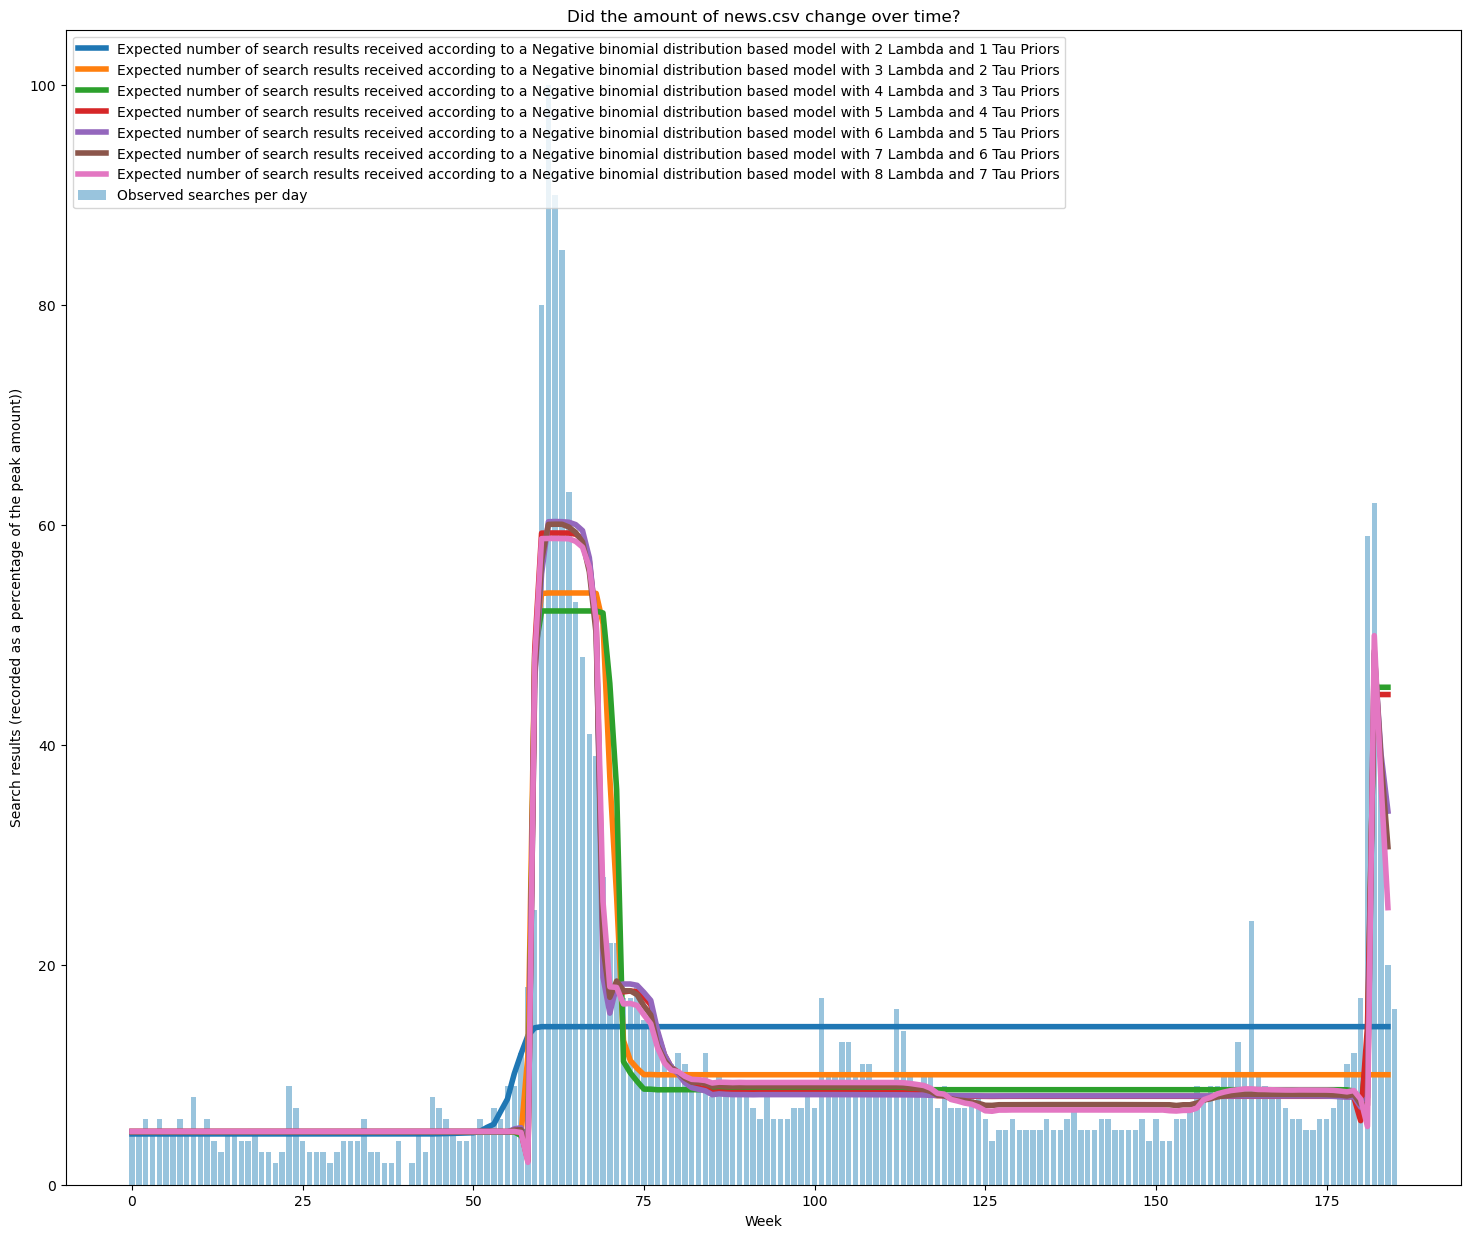

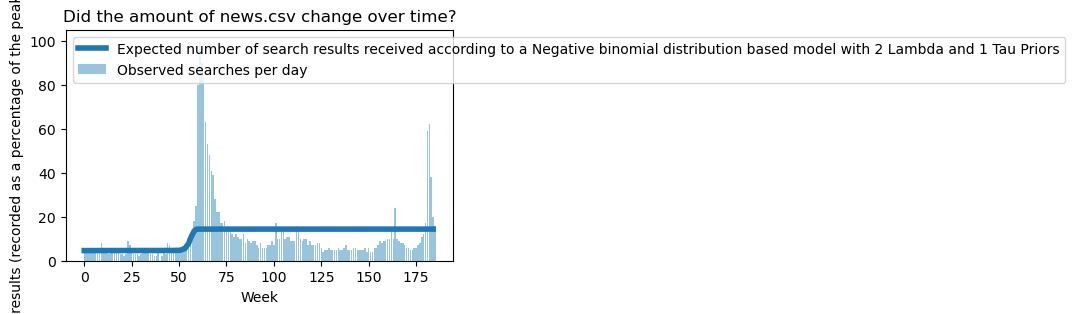

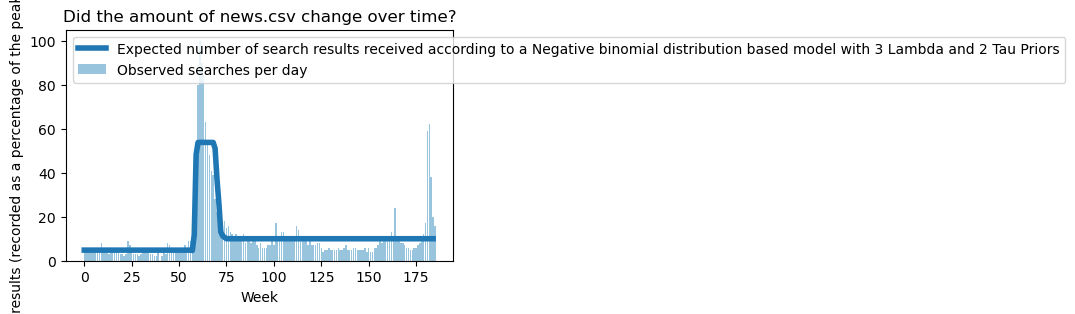

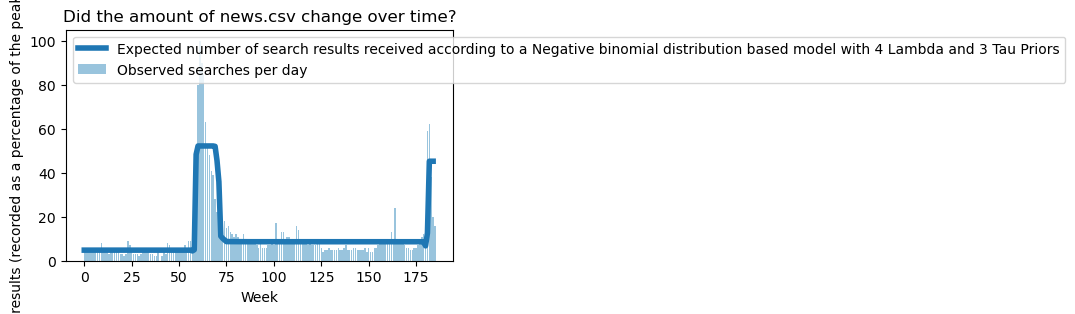

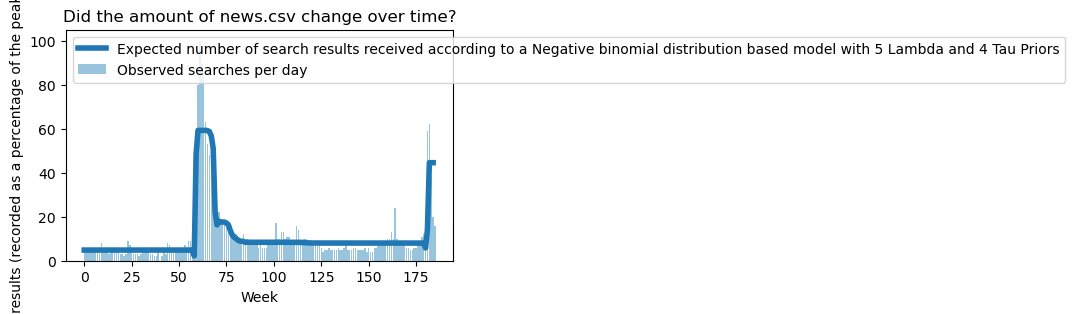

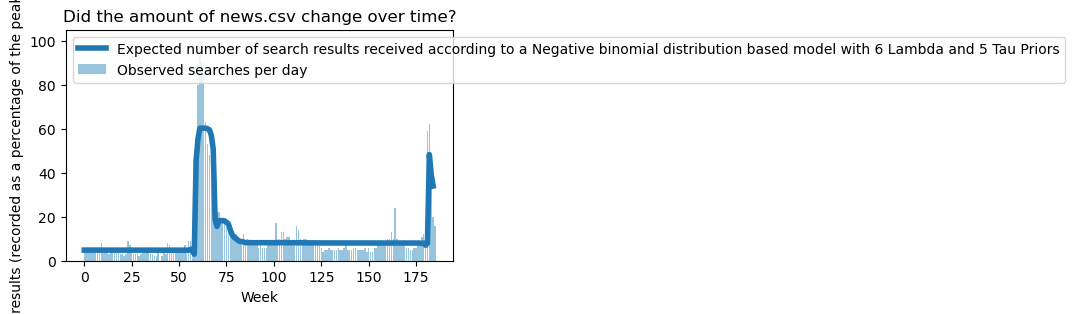

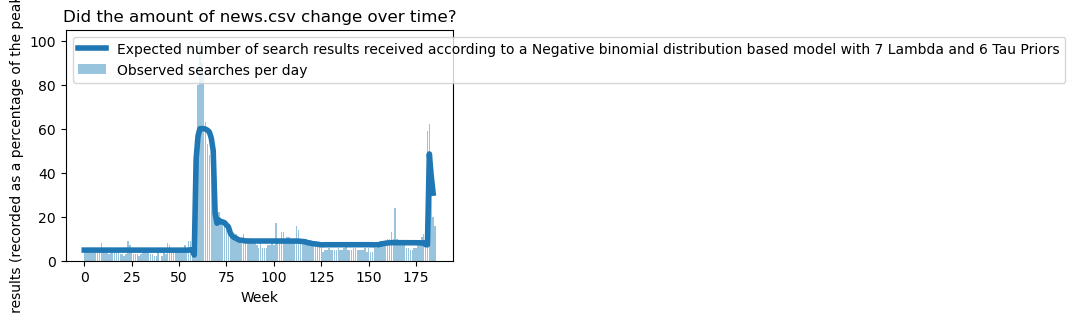

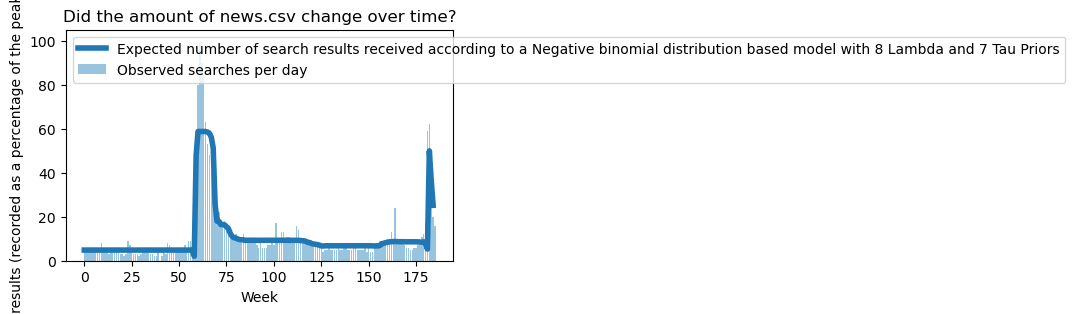

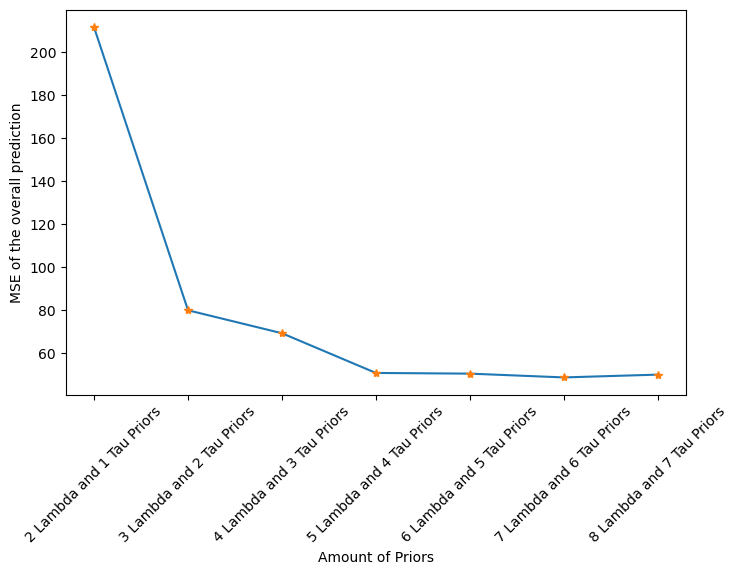

In [14]:
os.chdir('/Users/elliotbarlow/Desktop/dissertation/Methodology')
def amountofpriorsaccuracyrelation(file, observtype, start):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[start : ]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    calcarray = [ changefinder21(file, observtype, start,), changefinder32(file, observtype, start,), changefinder43(file, observtype, start,), changefinder54(file, observtype, start,), changefinder65(file, observtype, start,), changefinder76(file, observtype, start,), changefinder87(file, observtype, start,) ]
    plt.rcParams['figure.figsize'] = [18, 15]
    priorslist = ['2 Lambda and 1 Tau Priors', '3 Lambda and 2 Tau Priors', '4 Lambda and 3 Tau Priors', '5 Lambda and 4 Tau Priors', '6 Lambda and 5 Tau Priors', '7 Lambda and 6 Tau Priors', '8 Lambda and 7 Tau Priors']
    
    for calc in range(len(calcarray)):
        expected_texts_per_day = calcarray[calc][0]
        plt.plot(range(weeks-1), expected_texts_per_day, lw=4,
                 label = f"Expected number of search results received according to a {observtype} based model with {priorslist[calc]}")
        
    plt.bar(np.arange(weeks), values, color="#348ABD", alpha=0.5,
            label="Observed searches per day")
    name = file
    plt.xlabel("Week")
    plt.ylabel("Search results (recorded as a percentage of the peak amount))")
    plt.title(f"Did the amount of {file} change over time?")
    plt.legend(loc="upper left")
    plt.show()

    for calc in range(len(calcarray)):
        plt.rcParams['figure.figsize'] = [5, 3]
        expected_texts_per_day = calcarray[calc][0]
        plt.plot(range(weeks-1), expected_texts_per_day, lw=4,
                 label = f"Expected number of search results received according to a {observtype} based model with {priorslist[calc]}")
        
        plt.bar(np.arange(weeks), values, color="#348ABD", alpha=0.5,label="Observed searches per day")
        name = file
        plt.xlabel("Week")
        plt.ylabel("Search results (recorded as a percentage of the peak amount))")
        plt.title(f"Did the amount of {file} change over time?")
        plt.legend(loc="upper left")
        plt.show()
        
    MSElist = []
    for calc in range(len(calcarray)):
        MSE = calcarray[calc][1]
        MSElist.append(MSE)
        
    plt.rcParams['figure.figsize'] = [8, 5]
    plt.plot(priorslist, MSElist)
    plt.plot(priorslist, MSElist, '*', label = MSElist)
    plt.xlabel("Amount of Priors")
    plt.ylabel("MSE of the overall prediction")
    plt.xticks(rotation=45) 
    
amountofpriorsaccuracyrelation('news.csv', "Negative binomial distribution", 0)
